In [1]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as p3
import numpy as np
import random
import time

from functools import partial
from ipywidgets import interact, RadioButtons, IntSlider, FloatSlider, Dropdown, BoundedFloatText
from numpy.linalg import norm

random.seed(42) # начальное состояние генератора случайных чисел, чтобы можно было воспроизводить результаты.

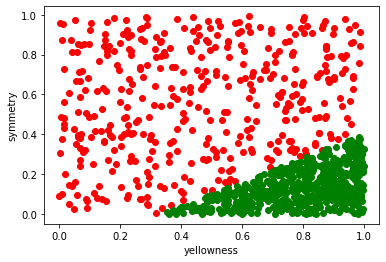

In [2]:
data = np.loadtxt("data.csv", delimiter=",")
pears = data[:, 2] == 1
apples = np.logical_not(pears)

%matplotlib inline
plt.scatter(data[apples][:, 0], data[apples][:, 1], color = "red")
plt.scatter(data[pears][:, 0], data[pears][:, 1], color = "green")
plt.xlabel("yellowness")
plt.ylabel("symmetry")
plt.show()

# красные 0 - яблоки, зеленые 1 - груши

In [3]:
data

array([[0.77942731, 0.25730527, 1.        ],
       [0.77700501, 0.0159154 , 1.        ],
       [0.97709225, 0.30420962, 1.        ],
       ...,
       [0.92721921, 0.13498618, 1.        ],
       [0.01582991, 0.48132194, 0.        ],
       [0.96796389, 0.30857107, 1.        ]])

In [4]:
class Perceptron:

    """
        Инициализируем наш объект - перцептрон.
        w - вектор весов размера (m, 1), где m - количество переменных
        b - число
    """
    def __init__(self, w, b):
        self.w = w
        self.b = b

    """
        Метод рассчитывает ответ перцептрона при предъявлении одного примера
        single_input - вектор примера размера (m, 1).
        Метод возвращает число (0 или 1) или boolean (True/False)
    """
    def forward_pass(self, single_input):
        result = 0
        for i in range(0, len(self.w)):
            result += self.w[i] * single_input[i]
        result += self.b
        
        return int(result > 0)

    """
        Метод рассчитывает ответ перцептрона при предъявлении набора примеров
        input_matrix - матрица примеров размера (n, m), каждая строка - отдельный пример,
        n - количество примеров, m - количество переменных
        Возвращает вертикальный вектор размера (n, 1) с ответами перцептрона
        (элементы вектора - boolean или целые числа (0 или 1))
    """
    def vectorized_forward_pass(self, input_matrix):
        return (input_matrix.dot(self.w) + self.b) > 0
    
    def train_on_single_example(self, example, y):
        """
        принимает вектор активации входов example формы (m, 1) 
        и правильный ответ для него (число 0 или 1 или boolean),
        обновляет значения весов перцептрона в соответствии с этим примером
        и возвращает размер ошибки, которая случилась на этом примере до изменения весов (0 или 1)
        (на её основании мы потом построим интересный график)
        """

        predict = float(np.dot(self.w.T, example) + self.b) > 0
        error = y - predict
        self.w = self.w + error * example
        self.b = self.b + error
        return error
    
    
""" Более сложный вариант написания функции 
    def vectorized_forward_pass(self, input_matrix):
        # np.full - возвращает новый массив, указанной формы и типа
        # np.r_ - преобразует срез в строку, а последовательности соединяет вдоль первой оси
        # Для нас достаточно, что он добавляет к матрице строку 
        w = np.r_[np.full((1,1), self.b), self.w]                             # Добавили b первой строкой к вектору весов     
        
        input_matrix_b = np.c_[np.ones(len(input_matrix)).T, input_matrix]    # Добавили 1 первым элементом каждой строки     

        yhat = input_matrix_b.dot(w1)                                         # Скалярное произведение двух матриц

        return yhat > 0                                                       # Превратили в вектор 1 и 0
        
"""

' Более сложный вариант написания функции \n    def vectorized_forward_pass(self, input_matrix):\n        # np.full - возвращает новый массив, указанной формы и типа\n        # np.r_ - преобразует срез в строку, а последовательности соединяет вдоль первой оси\n        # Для нас достаточно, что он добавляет к матрице строку \n        w = np.r_[np.full((1,1), self.b), self.w]                             # Добавили b первой строкой к вектору весов     \n        \n        input_matrix_b = np.c_[np.ones(len(input_matrix)).T, input_matrix]    # Добавили 1 первым элементом каждой строки     \n\n        yhat = input_matrix_b.dot(w1)                                         # Скалярное произведение двух матриц\n\n        return yhat > 0                                                       # Превратили в вектор 1 и 0\n        \n'

In [5]:
## Определим разные полезные функции

def sigmoid(x):
    """сигмоидальная функция, работает и с числами, и с векторами (поэлементно)"""
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    """производная сигмоидальной функции, работает и с числами, и с векторами (поэлементно)"""
    return sigmoid(x) * (1 - sigmoid(x))

In [8]:
def J_quadratic(neuron, X, y):
    """
    Оценивает значение квадратичной целевой функции.
    Всё как в лекции, никаких хитростей.

    neuron - нейрон, у которого есть метод vectorized_forward_pass, предсказывающий значения на выборке X
    X - матрица входных активаций (n, m)
    y - вектор правильных ответов (n, 1)
        
    Возвращает значение J (число)
    """
    
    assert y.shape[1] == 1, 'Incorrect y shape'
    
    return 0.5 * np.mean((neuron.vectorized_forward_pass(X) - y) ** 2)

def J_quadratic_derivative(y, y_hat):
    """
    Вычисляет вектор частных производных целевой функции по каждому из предсказаний.
    y_hat - вертикальный вектор предсказаний,
    y - вертикальный вектор правильных ответов,
    
    В данном случае функция смехотворно простая, но если мы захотим поэкспериментировать 
    с целевыми функциями - полезно вынести эти вычисления в отдельный этап.
    
    Возвращает вектор значений производной целевой функции для каждого примера отдельно.
    """
    
    assert y_hat.shape == y.shape and y_hat.shape[1] == 1, 'Incorrect shapes'
    
    return (y_hat - y) / len(y)
    
def compute_grad_analytically(neuron, X, y, J_prime=J_quadratic_derivative):
    """
    Аналитическая производная целевой функции
    neuron - объект класса Neuron
    X - вертикальная матрица входов формы (n, m), на которой считается сумма квадратов отклонений
    y - правильные ответы для примеров из матрицы X
    J_prime - функция, считающая производные целевой функции по ответам
    
    Возвращает вектор размера (m, 1)
    """
    
    # Вычисляем активации
    # z - вектор результатов сумматорной функции нейрона на разных примерах
    
    z = neuron.summatory(X)
    y_hat = neuron.activation(z)

    # Вычисляем нужные нам частные производные
    dy_dyhat = J_prime(y, y_hat)
    dyhat_dz = neuron.activation_function_derivative(z)
    
    # осознайте эту строчку:
    dz_dw = X

    # а главное, эту:
    grad = ((dy_dyhat * dyhat_dz).T).dot(dz_dw)
    
    # можно было написать в два этапа. Осознайте, почему получается одно и то же
    # grad_matrix = dy_dyhat * dyhat_dz * dz_dw
    # grad = np.sum(, axis=0)
    
    # Сделаем из горизонтального вектора вертикальный
    grad = grad.T
    
    return grad

def compute_grad_numerically(neuron, X, y, J=J_quadratic, eps=10e-2):
    """
    Численная производная целевой функции
    neuron - объект класса Neuron
    X - вертикальная матрица входов формы (n, m), на которой считается сумма квадратов отклонений
    y - правильные ответы для тестовой выборки X
    J - целевая функция, градиент которой мы хотим получить
    eps - размер $\delta w$ (малого изменения весов)
    """

    initial_cost = J(neuron, X, y)
    w_0 = neuron.w
    num_grad = np.zeros(w_0.shape)
    
    for i in range(len(w_0)):
        
        old_wi = neuron.w[i].copy()
        # Меняем вес
        neuron.w[i] += eps
        
        # Считаем новое значение целевой функции и вычисляем приближенное значение градиента
        num_grad[i] = (J(neuron, X, y) - initial_cost)/eps
        
        # Возвращаем вес обратно. Лучше так, чем -= eps, чтобы не накапливать ошибки округления
        neuron.w[i] = old_wi
            
    # проверим, что не испортили нейрону веса своими манипуляциями
    assert np.allclose(neuron.w, w_0), "МЫ ИСПОРТИЛИ НЕЙРОНУ ВЕСА"
    return num_grad

In [6]:
class Neuron:
    
    def __init__(self, weights, activation_function=sigmoid, activation_function_derivative=sigmoid_prime):
        """
        weights - вертикальный вектор весов нейрона формы (m, 1), weights[0][0] - смещение
        activation_function - активационная функция нейрона, сигмоидальная функция по умолчанию
        activation_function_derivative - производная активационной функции нейрона
        """
        
        assert weights.shape[1] == 1, "Incorrect weight shape"
        
        self.w = weights
        self.activation_function = activation_function
        self.activation_function_derivative = activation_function_derivative
        
    def forward_pass(self, single_input):
        """
        активационная функция логистического нейрона
        single_input - вектор входов формы (m, 1), 
        первый элемент вектора single_input - единица (если вы хотите учитывать смещение)
        """
        
        result = 0
        for i in range(self.w.size):
            result += float(self.w[i] * single_input[i])
        return self.activation_function(result)
    
    """
        Вычисляет результат сумматорной функции для каждого примера из input_matrix. 
        input_matrix - матрица примеров размера (n, m), каждая строка - отдельный пример,
        n - количество примеров, m - количество переменных.
        Возвращает вектор значений сумматорной функции размера (n, 1).
    """
    def summatory(self, input_matrix):
        self.summatory_activation = input_matrix.dot(self.w)
        return self.summatory_activation 

    """
        Вычисляет для каждого примера результат активационной функции,
        получив на вход вектор значений сумматорной функций
        summatory_activation - вектор размера (n, 1), 
        где summatory_activation[i] - значение суммматорной функции для i-го примера.
        Возвращает вектор размера (n, 1), содержащий в i-й строке 
        значение активационной функции для i-го примера.
    """
    def activation(self, summatory_activation):
        return sigmoid(self.summatory_activation)

    """
        Векторизованная активационная функция логистического нейрона.
        input_matrix - матрица примеров размера (n, m), каждая строка - отдельный пример,
        n - количество примеров, m - количество переменных.
        Возвращает вертикальный вектор размера (n, 1) с выходными активациями нейрона
        (элементы вектора - float)
    """
    def vectorized_forward_pass(self, input_matrix):
        return self.activation(self.summatory(input_matrix))
    
        
    def SGD(self, X, y, batch_size, learning_rate=0.1, eps=1e-6, max_steps=200):
        """
        Внешний цикл алгоритма градиентного спуска.
        X - матрица входных активаций (n, m)
        y - вектор правильных ответов (n, 1)
        
        learning_rate - константа скорости обучения
        batch_size - размер батча, на основании которого 
        рассчитывается градиент и совершается один шаг алгоритма
        
        eps - критерий остановки номер один: если разница между значением целевой функции 
        до и после обновления весов меньше eps - алгоритм останавливается. 
        Вторым вариантом была бы проверка размера градиента, а не изменение функции,
        что будет работать лучше - неочевидно. В заданиях используйте первый подход.
        
        max_steps - критерий остановки номер два: если количество обновлений весов 
        достигло max_steps, то алгоритм останавливается
        
        Метод возвращает 1, если отработал первый критерий остановки (спуск сошёлся) 
        и 0, если второй (спуск не достиг минимума за отведённое время).
        """
        
        # Этот метод необходимо реализовать
        
        pass
    
    def update_mini_batch(self, X, y, learning_rate, eps):
        """
        X - матрица размера (batch_size, m)
        y - вектор правильных ответов размера (batch_size, 1)
        learning_rate - константа скорости обучения
        eps - критерий остановки номер один: если разница между значением целевой функции 
        до и после обновления весов меньше eps - алгоритм останавливается. 
        
        Рассчитывает градиент (не забывайте использовать подготовленные заранее внешние функции) 
        и обновляет веса нейрона. Если ошибка изменилась меньше, чем на eps - возвращаем 1, 
        иначе возвращаем 0.
        """
        grad = compute_grad_analytically(self, X, y)
        
        err_was = J_quadratic(self, X, y)
        
        self.w = self.w - learning_rate * grad 
        
        err_now = J_quadratic(self, X, y)
        return 1 if err_was - err_now < eps else 0


nabla_j = compute_grad_analytically(self, X, y)
    delta_w = learning_rate * nabla_j
    J_old = J_quadratic(self, X, y)  
    self.w -= delta_w  
    j_new = J_quadratic(self, X, y)    
    if J_old - j_new < eps:
        return 1
    else:
        return 0